<font size="5">Section 6: Structural Equation Modelling</font>

## Housekeeping and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
import scipy 
from scipy.linalg import eigh, cholesky
from scipy.stats import norm
import linearmodels.panel as lmp
from pylab import plot, show, axis, subplot, xlabel, ylabel, grid
import semopy 
from factor_analyzer import FactorAnalyzer

%matplotlib inline

First, we simulate some data to use all different methods. Nine continuous variables and nine binary variables, all with different levels of correlation among them.

In [2]:
# experiment parameters
np.random.seed(123) #set seed
nsize = 10000

# variance-covariance matrix (simetric)
cov = np.array([
        [  3.40, -2.75, -2.00],
        [ -2.75,  5.50,  1.50],
        [ -2.00,  1.50,  1.25]
    ])

# correlated variables 
X = norm.rvs(size=(3, nsize))
evals, evecs = eigh(cov)
c = np.dot(evecs, np.diag(np.sqrt(evals)))
Xa = np.dot(c, X)
Xa = Xa.transpose()
X = X.transpose()
X = pd.DataFrame(X)
Xa = pd.DataFrame(Xa)
Xc = pd.DataFrame(np.c_[X,Xa], columns=['X1','X2','X3','X4','X5','X6'])
Xc['X7'] = Xc['X2'] + Xc['X5']
Xc['X8'] = Xc['X1'] + Xc['X5'] 
Xc['X9'] = Xc['X2'] + Xc['X6'] 

# binary variables based of continous variables
Xb = pd.DataFrame()
for col in Xc:
  Xb[col] = pd.qcut(Xc[col], 2, [0,1])

#data description
Xb.describe()


,X1,X2,X3,X4,X5,X6,X7,X8,X9
count,10000,10000,10000,10000,10000,10000,10000,10000,10000
unique,2,2,2,2,2,2,2,2,2
top,0,0,0,0,0,0,0,0,0
freq,5000,5000,5000,5000,5000,5000,5000,5000,5000


## PCA

PCA for continous variables in this example using sklearn.

In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_features = pca.fit_transform(Xc)
print(pca.explained_variance_ratio_)

[0.70904559 0.22913056 0.06182385]


In [4]:
pca_vectors = pd.DataFrame(data = pca.components_)
pca_vectors.head()

,0,1,2,3,4,5,6,7,8
0,0.031173,0.003378,-0.222667,-0.361357,0.479615,0.215838,0.482992,0.510787,0.219216
1,-0.047268,0.395973,-0.011061,-0.364311,-0.332058,0.232996,0.063916,-0.379326,0.628970
2,0.752066,0.094902,0.100046,0.170788,-0.295688,0.103681,-0.200787,0.456378,0.198583


In [5]:
pca_df = pd.DataFrame(data=pca_features,columns=['PC1', 'PC2', 'PC3'])
pca_df.describe().apply(lambda s: s.apply('{0:.3f}'.format))

,PC1,PC2,PC3
count,10000.000,10000.000,10000.000
mean,0.000,0.000,-0.000
std,4.419,2.512,1.305
min,-15.979,-8.920,-4.914
25%,-3.000,-1.730,-0.888
50%,0.017,0.001,0.001
75%,2.973,1.690,0.871
max,16.097,10.243,5.157


In [6]:
pca_df.corr().apply(lambda s: s.apply('{0:.3f}'.format))

,PC1,PC2,PC3
PC1,1.000,0.000,0.000
PC2,0.000,1.000,0.000
PC3,0.000,0.000,1.000


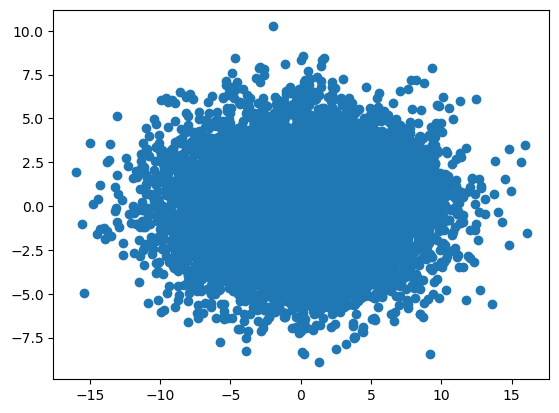

In [7]:
plt.scatter(pca_df['PC1'],pca_df['PC2'])

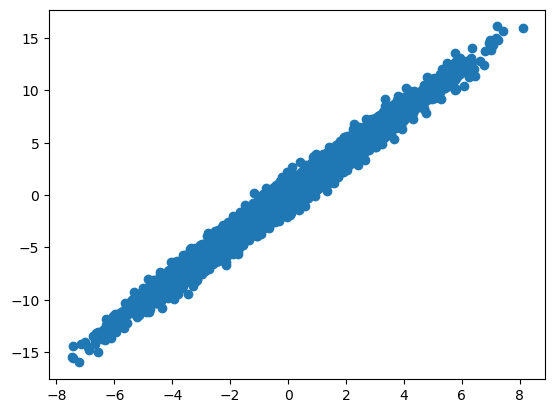

In [8]:
plt.scatter(Xc['X7'],pca_df['PC1'])

## EFA

EFA example using factor_analyzer

In [33]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors=3, rotation='promax')
fa.fit(Xc)

FactorAnalyzer(rotation_kwargs={})

In [34]:
fa.loadings_

array([[-0.03487373,  0.10548121,  1.00328716],
       [-0.44951466,  1.06187463,  0.02031994],
       [-0.96047954, -0.10836013,  0.08990928],
       [-0.62984551, -0.58164478,  0.1333002 ],
       [ 1.06947595, -0.31256919, -0.08802168],
       [ 0.55073345,  0.65903813,  0.10388396],
       [ 0.93675305,  0.15881277, -0.08485118],
       [ 0.96605162, -0.24462346,  0.31648911],
       [ 0.09092536,  0.96582186,  0.07345973]])

In [35]:
fa.get_eigenvalues()

(array([ 5.52726684e+00,  2.33231106e+00,  1.14042210e+00,  8.11050308e-16,
         6.33614691e-16,  1.94542594e-16,  3.77443858e-18, -2.47056753e-16,
        -3.43815490e-16]),
 array([ 5.46469834e+00,  2.49399111e+00,  1.16148033e+00,  2.24660867e-01,
         1.32436425e-01, -1.03781375e-03, -7.49967600e-02, -1.65949678e-01,
        -2.43848259e-01]))

In [36]:
fa.get_factor_variance()

(array([4.78862148, 3.03866133, 1.16415176]),
 array([0.53206905, 0.33762904, 0.1293502 ]),
 array([0.53206905, 0.86969809, 0.99904828]))

In [42]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors=2, rotation='promax')
fa.fit(Xc)

FactorAnalyzer(n_factors=2, rotation_kwargs={})

In [43]:
fa.loadings_

array([[ 0.10412397, -0.0054451 ],
       [-0.51616571,  1.0623926 ],
       [-0.91965126, -0.17261043],
       [-0.55233098, -0.64107736],
       [ 1.0582279 , -0.25293506],
       [ 0.51091829,  0.69088806],
       [ 0.89388675,  0.22233782],
       [ 0.98654701, -0.2170152 ],
       [ 0.03139194,  0.98551393]])

In [44]:
fa.get_eigenvalues()

(array([ 5.52726684e+00,  2.33231106e+00,  1.14042210e+00,  8.11050308e-16,
         6.33614691e-16,  1.94542594e-16,  3.77443858e-18, -2.47056753e-16,
        -3.43815490e-16]),
 array([ 5.41939745,  2.50864601,  0.46805758,  0.22247109,  0.04429584,
        -0.13693165, -0.17829255, -0.21235961, -0.37445751]))

In [45]:
fa.get_factor_variance()

(array([4.58227457, 3.17855208]),
 array([0.50914162, 0.35317245]),
 array([0.50914162, 0.86231407]))

EFA example using semopy

In [46]:
print(semopy.efa.explore_cfa_model(Xc))

eta1 =~ X7 + X3 + X4 + X6 + X5 + X8 + X9
eta2 =~ X6 + X4 + X9 + X5 + X2 + X8



## Latent clases

Latent class analysis not available on Python at this time. Example available in R for the poLCA library at https://rpubs.com/cyanjiner/889802

## Latent growth

Latent growth modelling is not available on Python at this time. Example available in R for the lavaan library at https://lavaan.ugent.be/tutorial/growth.html

Latent trajectory class (growth curves and class membership) is not available on Python at this time. Example available in R for the traj library in class files.

## General CFA

Example available using semopy library

In [ ]:
from semopy.examples import political_democracy
from semopy import Model

desc = political_democracy.get_model()
data = political_democracy.get_data()

model = Model(desc)
model.fit(data)
factors = model.predict_factors(data)
print(factors.head())

## Mixture model

Example available using sklearn library (next week).

<font size="3">**Tarea 4**</font>

<u> *Instrucciones* </u>

Los resultados de los ejericicios propuestos se deben entregar como un notebook por correo electronico a *juancaros@udec.cl* el dia 6/12 hasta las 21:00. 


Preguntas:

